In [1]:
import sys
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# Add parent directory to path to allow import of config.py
sys.path.append("..")

import config as conf

For our baseline or 'naive' model, we will use a simple linear regression model on enrolment as a function of time. This model is not expected to perform well, but it will give us a baseline for the simplest possible model to compare other models to.

In [2]:
data = pd.read_csv(f'{conf.DATA_PATH}{conf.FORMATTED_DATAFILE}')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 24 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Census Enrollment                14 non-null     float64
 1   Census Fill Rate                 14 non-null     float64
 2   Count of Migrated Data           14 non-null     float64
 3   Current Enrollment               14 non-null     float64
 4   Current Fill Rate                14 non-null     float64
 5   Enrollment Capacity              14 non-null     float64
 6   Ftef                             14 non-null     float64
 7   Ftes                             14 non-null     float64
 8   Ftes/Ftef                        14 non-null     float64
 9   Number Retained                  14 non-null     float64
 10  Number Successful                14 non-null     float64
 11  Retention Rate                   14 non-null     float64
 12  Sec. Count              

To do a simple x, y linear fit, we first need to do a little data formatting. The goal is to make a timeseries where the date is x and enrollment is y.

In [3]:
def decode_year(row):
    '''Helper function for apply - takes row and returns
    name of column which contains a 1, removes year_ prefix.'''
    
    for col in years.columns:
        if row[col]==1:
            col = col.replace("year_", "")
            return col
        
def decode_semester(row):
    '''Helper function for apply - takes row and returns
    name of column which contains a 1, removes semester_ prefix.'''
    
    for col in semesters.columns:
        if row[col]==1:
            col = col.replace("semester_", "")
            return col
        
def decode_semester_strings(semesters):
    '''Takes a list of semester string identifiers and translates
    them into month and day of census. Returns two lists with month
    and day numbers'''
    
    census_months = []
    census_days = []

    for semester in list(semesters):

        if semester == 'FA':
            census_months.append(9)
            census_days.append(8)

        elif semester == 'SP':
            census_months.append(2)
            census_days.append(8)

        elif semester == 'SU':
            census_months.append(5)
            census_days.append(14)

    return census_months, census_days

def make_xy_data(data):
    '''Wapper function takes formatted data and recovers two lists - one of census enrollment
    numbers (returned as y) and the census data (returned as x)'''
    
    global years
    years = data.filter(regex=("year.*"))
    
    global semesters
    semesters = data.filter(regex=("semester.*"))

    decoded_years = years.apply(decode_year, axis=1)
    decoded_semesters = semesters.apply(decode_semester, axis=1)

    census_months, census_days = decode_semester_strings(decoded_semesters)

    x = pd.to_datetime(dict(year=decoded_years, month=census_months, day=census_days))
    y = data['Census Enrollment']
    
    return x, y

In [4]:
# Get census data and corresponding enrollment number from
# each row in the data

x, y = make_xy_data(data)

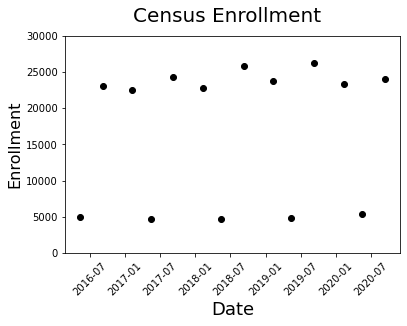

In [5]:
# Plot enrollment numbers over time

fig = plt.figure()
plt.scatter(x, y, color='black')
plt.axis([None, None, 0, 30000])
plt.xticks(rotation = 45)
fig.suptitle('Census Enrollment', fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Enrollment', fontsize=16)
plt.show()

The orignal plan was to fit this data with one line and call that the minimal model. But looking at the data, I think that is going a bit to far in terms of oversimplifying on purpose to make the other models look good. I think that what we have to do is use two linear fits, one to summer semesters and the other to fall and spring.

In [6]:
# Split data into summer and fall-spring sets, then remake x, y data for each

SU_data = data[data['semester_SU'] == 1]
SU_x, SU_y = make_xy_data(SU_data)

FA_SP_data = data[data['semester_SU'] == 0 ]
FA_SP_x, FA_SP_y = make_xy_data(FA_SP_data)

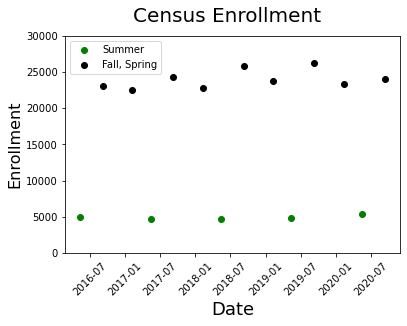

In [7]:
# Replot census enrollment over time as two series

fig = plt.figure()
plt.scatter(SU_x, SU_y, c='green', label='Summer')
plt.scatter(FA_SP_x, FA_SP_y, c='black', label='Fall, Spring')
plt.legend(loc='upper left')
plt.axis([None, None, 0, 30000])
plt.xticks(rotation = 45)
fig.suptitle('Census Enrollment', fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Enrollment', fontsize=16)
plt.show()

In [8]:
# Fit linear models to the summer and fall-spring data, then make
# predictions from the respective x vectors

# Convert pandas datatime to ms timestamp
SU_x_timestamp = SU_x.values.astype(np.int64) // 10 ** 9
FA_SP_x_timestamp = FA_SP_x.values.astype(np.int64) // 10 ** 9

# Reshape and convert to numpy array
SU_x_timestamp = np.array(SU_x_timestamp).reshape(-1, 1)
FA_SP_x_timestamp = np.array(FA_SP_x_timestamp).reshape(-1, 1)

# Fit linear models
SU_linear_model = LinearRegression().fit(SU_x_timestamp, SU_y)
FA_SP_linear_model = LinearRegression().fit(FA_SP_x_timestamp, FA_SP_y)

# Use models to make predictions
SU_predictions = SU_linear_model.predict(SU_x_timestamp)
FA_SP_predictions = FA_SP_linear_model.predict(FA_SP_x_timestamp)

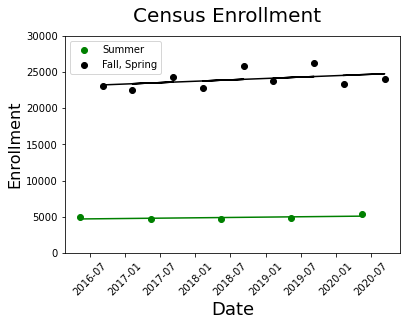

In [9]:
# Replot census enrollment over time as two series
# with linear fits

fig = plt.figure()
plt.scatter(SU_x, SU_y, c='green', label='Summer')
plt.plot(SU_x, SU_predictions, c='green')
plt.scatter(FA_SP_x, FA_SP_y, c='black', label='Fall, Spring')
plt.plot(FA_SP_x, FA_SP_predictions, c='black')
plt.legend(loc='upper left')
plt.axis([None, None, 0, 30000])
plt.xticks(rotation = 45)
fig.suptitle('Census Enrollment', fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Enrollment', fontsize=16)
plt.show()

In [10]:
# Score summer model
SU_scikit_R_sqr = SU_linear_model.score(SU_x_timestamp, SU_y)
SU_MAE = mean_absolute_error(SU_y, SU_predictions)
print('SciKit-learn R\u00b2: {}'.format(np.round(SU_scikit_R_sqr, 3)))
print(f'Mean absolute error: {int(SU_MAE)}')

SciKit-learn R²: 0.33
Mean absolute error: 189


In [11]:
# Score winter/fall model
FA_SP_scikit_R_sqr = FA_SP_linear_model.score(FA_SP_x_timestamp, FA_SP_y)
FA_SP_MAE = mean_absolute_error(FA_SP_y, FA_SP_predictions)
print('SciKit-learn R\u00b2: {}'.format(np.round(FA_SP_scikit_R_sqr, 3)))
print(f'Mean absolute error: {int(FA_SP_MAE)}')

SciKit-learn R²: 0.171
Mean absolute error: 950


In [12]:
# Get aggragate MAE for both models
n_SU_points = len(SU_predictions)
n_FA_SP_points = len(FA_SP_predictions)
n = n_SU_points + n_FA_SP_points

MAE = int((SU_MAE*(n_SU_points/n)) + (FA_SP_MAE*(n_FA_SP_points/n)))
print(f'Aggregate MAE: {MAE}')

Aggregate MAE: 678


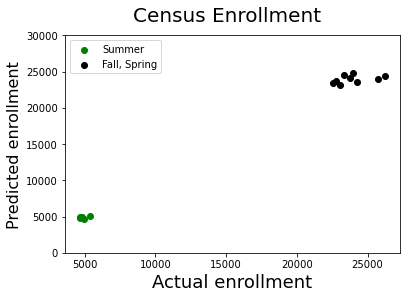

In [13]:
fig = plt.figure()
plt.scatter(SU_y, SU_predictions, c='green', label='Summer')
plt.scatter(FA_SP_y, FA_SP_predictions, c='black', label='Fall, Spring')
plt.legend(loc='upper left')
plt.axis([None, None, 0, 30000])
fig.suptitle('Census Enrollment', fontsize=20)
plt.xlabel('Actual enrollment', fontsize=18)
plt.ylabel('Predicted enrollment', fontsize=16)
plt.show()

OK - looks pretty good. The one caveat here is we have used all of the data in the fit. Therefore we don't know how well these models will generalize. Let't try again with a train/test split.

In [14]:
# Train test split fall-spring data

# Combine data into one dataframe
FA_SP_data = pd.DataFrame(list(zip(FA_SP_x, FA_SP_y)),columns =['date', 'enrollment'])

# Split data randomly into training and testing sets
FA_SP_training_data = FA_SP_data.sample(frac=conf.TRAIN_TEST_SPLIT)
FA_SP_test_data = FA_SP_data.drop(FA_SP_training_data.index)

# Seperate dependent and independent variable
FA_SP_training_x = FA_SP_training_data.copy()
FA_SP_test_x = FA_SP_test_data.copy()

FA_SP_training_y = FA_SP_training_x.pop('enrollment')
FA_SP_test_y = FA_SP_test_x.pop('enrollment')

In [15]:
# Train test split summer data

# Combine data into one dataframe
SU_data = pd.DataFrame(list(zip(SU_x, SU_y)),columns =['date', 'enrollment'])

# Split data randomly into training and testing sets
SU_training_data = SU_data.sample(frac=conf.TRAIN_TEST_SPLIT)
SU_test_data = SU_data.drop(SU_training_data.index)

# Separate dependent and independent variable
SU_training_x = SU_training_data.copy()
SU_test_x = SU_test_data.copy()

SU_training_y = SU_training_x.pop('enrollment')
SU_test_y = SU_test_x.pop('enrollment')

In [16]:
# Re-fit linear models to the summer and fall-spring training 
# data, then make predictions for the test sets

# Convert pandas datatime to ms timestamp
SU_training_x_timestamp = SU_training_x.values.astype(np.int64) // 10 ** 9
FA_SP_training_x_timestamp = FA_SP_training_x.values.astype(np.int64) // 10 ** 9

SU_test_x_timestamp = SU_test_x.values.astype(np.int64) // 10 ** 9
FA_SP_test_x_timestamp = FA_SP_test_x.values.astype(np.int64) // 10 ** 9

# Reshape and convert to numpy array
SU_training_x_timestamp = np.array(SU_training_x_timestamp).reshape(-1, 1)
FA_SP_training_x_timestamp = np.array(FA_SP_training_x_timestamp).reshape(-1, 1)

# Fit linear models
SU_linear_model = LinearRegression().fit(SU_training_x_timestamp, SU_training_y)
FA_SP_linear_model = LinearRegression().fit(FA_SP_training_x_timestamp, FA_SP_training_y)

# Use models to make predictions
SU_test_predictions = SU_linear_model.predict(SU_test_x_timestamp)
FA_SP_test_predictions = FA_SP_linear_model.predict(FA_SP_test_x_timestamp)

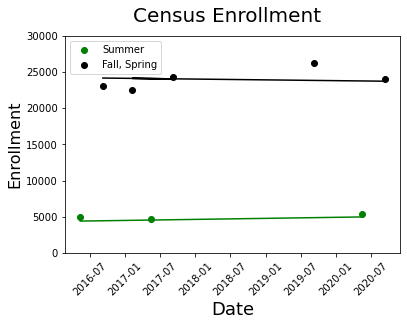

In [17]:
# Replot the models against the test data to get a feel
# for how we would do against unseen data

fig = plt.figure()
plt.scatter(SU_test_x, SU_test_y, c='green', label='Summer')
plt.plot(SU_test_x, SU_test_predictions, c='green')
plt.scatter(FA_SP_test_x, FA_SP_test_y, c='black', label='Fall, Spring')
plt.plot(FA_SP_test_x, FA_SP_test_predictions, c='black')
plt.legend(loc='upper left')
plt.axis([None, None, 0, 30000])
plt.xticks(rotation = 45)
fig.suptitle('Census Enrollment', fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Enrollment', fontsize=16)
plt.show()

In [18]:
# Score summer model on test set
SU_scikit_R_sqr = SU_linear_model.score(SU_test_x_timestamp, SU_test_y)
SU_MAE = mean_absolute_error(SU_test_y, SU_test_predictions)
print('SciKit-learn R\u00b2: {}'.format(np.round(SU_scikit_R_sqr, 3)))
print(f'Mean absolute error: {int(SU_MAE)}')

SciKit-learn R²: -0.923
Mean absolute error: 337


In [19]:
# Score fall-spring model on test set
FA_SP_scikit_R_sqr = FA_SP_linear_model.score(FA_SP_test_x_timestamp, FA_SP_test_y)
FA_SP_MAE = mean_absolute_error(FA_SP_test_y, FA_SP_test_predictions)
print('SciKit-learn R\u00b2: {}'.format(np.round(FA_SP_scikit_R_sqr, 3)))
print(f'Mean absolute error: {int(FA_SP_MAE)}')

SciKit-learn R²: -0.189
Mean absolute error: 1103


In [20]:
# Get aggragate MAE for both models
n_SU_points = len(SU_test_predictions)
n_FA_SP_points = len(FA_SP_test_predictions)
n = n_SU_points + n_FA_SP_points

MAE = int((SU_MAE*(n_SU_points/n)) + (FA_SP_MAE*(n_FA_SP_points/n)))
print(f'Aggregate MAE: {MAE}')

Aggregate MAE: 816


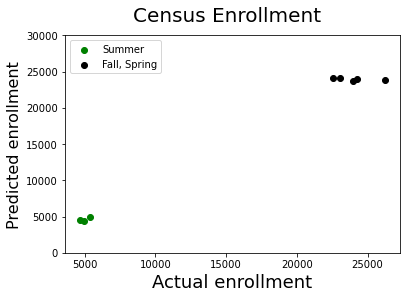

In [21]:
fig = plt.figure()
plt.scatter(SU_test_y, SU_test_predictions, c='green', label='Summer')
plt.scatter(FA_SP_test_y, FA_SP_test_predictions, c='black', label='Fall, Spring')
plt.legend(loc='upper left')
plt.axis([None, None, 0, 30000])
fig.suptitle('Census Enrollment', fontsize=20)
plt.xlabel('Actual enrollment', fontsize=18)
plt.ylabel('Predicted enrollment', fontsize=16)
plt.show()

OK, looking like the 'control' model is actually going to win! Let's bootstrap it and come up with some confidence intervals.

To do that, we need to encapsulate the above operations in functions so that we can easily loop over them.

In [22]:
def train_test_split(x, y, training_data_fraction):
    '''Takes x and y lists of data, combines then randomly 
    samples them. Returns a dict contatining train and test
    x and y datasets'''

    # Combine data into one dataframe
    data = pd.DataFrame(list(zip(x, y)),columns =['date', 'enrollment'])

    # Split data randomly into training and testing sets
    training_data = data.sample(frac=training_data_fraction)
    test_data = data.drop(training_data.index)

    # Seperate dependent and independent variable
    training_x = training_data.copy()
    test_x = test_data.copy()

    training_y = training_x.pop('enrollment')
    test_y = test_x.pop('enrollment')
    
    dataset = {}
    dataset['training_x'] = training_x
    dataset['test_x'] = test_x
    dataset['training_y'] = training_y
    dataset['test_y'] = test_y
    
    return dataset

def train_linear_model(dataset):
    '''Takes dataset, trains simple linear model,
    returns trained model'''
    
    # Extract data from dataset
    training_x = dataset['training_x']
    test_x = dataset['test_x']
    training_y = dataset['training_y']
    test_y = dataset['test_y']
    
    # Convert pandas datatime to ms timestamp
    training_x_timestamp = training_x.values.astype(np.int64) // 10 ** 9
    test_x_timestamp = test_x.values.astype(np.int64) // 10 ** 9

    # Reshape and convert to numpy array
    training_x_timestamp = np.array(training_x_timestamp).reshape(-1, 1)

    # Fit linear model
    linear_model = LinearRegression().fit(training_x_timestamp, training_y)

    # Use models to make predictions
    test_predictions = linear_model.predict(test_x_timestamp)
    
    return linear_model, test_predictions
    
def score_models(
    SU_y, 
    SU_predictions,
    FA_SP_y,
    FA_SP_predictions
):
    '''Calculates aggragate MAE for both models using weighted avg.'''
    
    SU_MAE = mean_absolute_error(SU_y, SU_predictions)
    FA_SP_MAE = mean_absolute_error(FA_SP_y, FA_SP_predictions)
    n_SU_points = len(SU_predictions)
    n_FA_SP_points = len(FA_SP_predictions)
    n = n_SU_points + n_FA_SP_points

    MAE = int((SU_MAE*(n_SU_points/n)) + (FA_SP_MAE*(n_FA_SP_points/n)))
    
    return MAE

In [23]:
results = {}
results['test_set_scores'] = []
results['SU_models'] = []
results['FA_SP_models'] = []
results['test_labels'] = []
results['test_features'] = []
results['test_predictions'] = []

# Outer training loop
for i in range(conf.N_MODELS):
    print(f'Training model {i}', end='\r')
    
    SU_dataset = train_test_split(SU_x, SU_y, conf.TRAIN_TEST_SPLIT)
    FA_SP_dataset = train_test_split(FA_SP_x, FA_SP_y, conf.TRAIN_TEST_SPLIT)
    
    SU_model, SU_test_predictions = train_linear_model(SU_dataset)
    FA_SP_model, FA_SP_test_predictions = train_linear_model(FA_SP_dataset)
    
    MAE = score_models(
        SU_test_y, 
        SU_test_predictions,
        FA_SP_test_y,
        FA_SP_test_predictions
    )
    
    results['test_set_scores'].append(MAE)
    results['SU_models'].append(SU_model)
    results['FA_SP_models'].append(FA_SP_model)
    results['test_features'].extend(SU_dataset['test_x'])
    results['test_features'].extend(FA_SP_dataset['test_x'])
    results['test_labels'].extend(SU_dataset['test_y'])
    results['test_labels'].extend(FA_SP_dataset['test_y'])
    results['test_predictions'].extend(SU_test_predictions)
    results['test_predictions'].extend(FA_SP_test_predictions)

In [24]:
# Save results
pkl_filename = f'{conf.TRAINED_MODEL_PATH}{conf.SIMPLE_LINEAR_MODEL_RESULTS_FILE}'

with open(pkl_filename, 'wb') as file:
    pickle.dump(results, file)

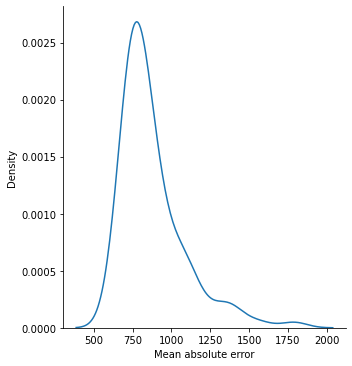

In [25]:
# Plot distribution of MAE scores from each model
sns.displot(results['test_set_scores'], kind="kde")
plt.xlabel('Mean absolute error')

plt.show()

Looks great, now lets set up to make predictions from the model ensemble.

In [26]:
# Empty list to hold summer predictions
SU_predictions = []

SU_x_timestamp = SU_x.values.astype(np.int64) // 10 ** 9
SU_x_timestamp = np.array(SU_x_timestamp).reshape(-1, 1)

for model in results['SU_models']:
    predicted_enrollment = model.predict(SU_x_timestamp)
    SU_predictions.append(predicted_enrollment)

# Average the predictions from each model
SU_predicted_enrollment = np.mean(np.array(SU_predictions), axis=0)

In [27]:
# Empty list to hold fall-spring predictions
FA_SP_predictions = []

FA_SP_x_timestamp = FA_SP_x.values.astype(np.int64) // 10 ** 9
FA_SP_x_timestamp = np.array(FA_SP_x_timestamp).reshape(-1, 1)

for model in results['FA_SP_models']:
    predicted_enrollment = model.predict(FA_SP_x_timestamp)
    FA_SP_predictions.append(predicted_enrollment)

# Average the predictions from each model
FA_SP_predicted_enrollment = np.mean(np.array(FA_SP_predictions), axis=0)

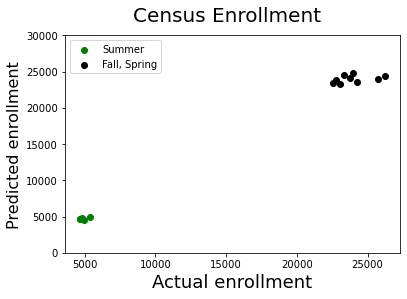

In [28]:
fig = plt.figure()
plt.scatter(SU_y, SU_predicted_enrollment, c='green', label='Summer')
plt.scatter(FA_SP_y, FA_SP_predicted_enrollment, c='black', label='Fall, Spring')
plt.legend(loc='upper left')
plt.axis([None, None, 0, 30000])
fig.suptitle('Census Enrollment', fontsize=20)
plt.xlabel('Actual enrollment', fontsize=18)
plt.ylabel('Predicted enrollment', fontsize=16)
plt.show()

In [29]:
MAE = score_models(
    SU_y, 
    SU_predicted_enrollment,
    FA_SP_y,
    FA_SP_predicted_enrollment
)

print(f'Ensamble MAE: {int(MAE)}')

Ensamble MAE: 687


Last thing before we move on - lets set up a confidence interval around an example prediction.

In [30]:
# Pick one point to predict
target = FA_SP_x_timestamp[3]

In [31]:
# Empty list to hold fall-spring predictions
FA_SP_predictions = []

for model in results['FA_SP_models']:
    predicted_enrollment = model.predict([target])
    FA_SP_predictions.extend(predicted_enrollment)

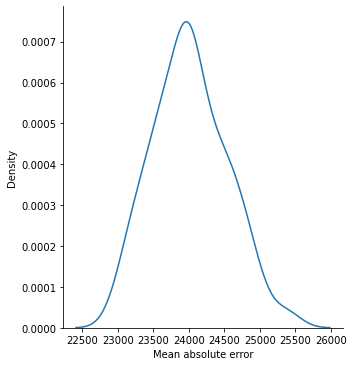

In [32]:
# Plot distribution of predictions from each model
sns.displot(FA_SP_predictions, kind="kde")
plt.xlabel('Mean absolute error')

plt.show()

In [33]:
import scipy.stats as st

mean = np.mean(FA_SP_predictions)
low, high = st.norm.interval(alpha=0.95, loc=np.mean(FA_SP_predictions), scale=st.sem(FA_SP_predictions))

print(f'Mean: {int(mean)}, 95% CI: {int(low)}-{int(high)}')
print(f'True value: {int(list(FA_SP_y)[3])}')

Mean: 24015, 95% CI: 23914-24117
True value: 25753
